In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt

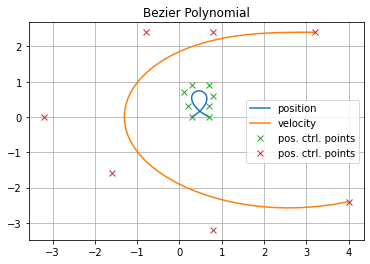

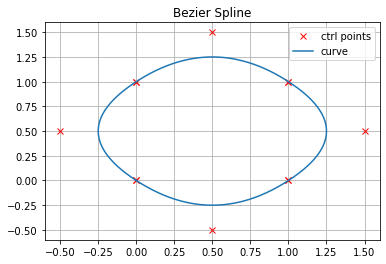

In [769]:
class Bezier(object):

    def __init__(self, p):
        self.p = np.asarray(p)
        self.N = len(p)-1
    
    @staticmethod
    def b(N, n, zeta):
        "bernstein coefficient"
        return math.comb(N, n)*(1 - zeta)**(N - n)*zeta**n

    def __call__(self, zeta):
        zeta = np.atleast_1d(zeta)
        p = self.p
        N = self.N
        r = np.zeros((len(zeta), p.shape[1]))
        for n in range(N+1):
            c = self.b(N, n, zeta)
            for d in range(p.shape[1]):
                r[:, d] += c*p[n, d]
        return r
    
    def diff(self, k=1):
        p = self.p
        for i in range(k):
            c = self.N + 1 - i
            p = c*np.diff(p, axis=0)
        return Bezier(p)


class BezierSpline(object):

    def __init__(self, p, leg_time):
        self.n_legs = len(p)
        self.leg_time = np.asarray(leg_time)
        self.bezier = []
        for p_i in p:
            self.bezier.append(Bezier(p_i))
    
    def __call__(self, t):
        """
        chops up time vector into appropriate leg and evaluates
        """
        t = np.asarray(t)
        t_vect = np.hstack(([0], np.cumsum(self.leg_time)))
        i_leg = np.zeros(len(t))
        i_leg[t < t_vect[0]] = 0
        i_leg[t > t_vect[-1]] = self.n_legs - 1
        for i in range(self.n_legs):
            i_leg[t >= t_vect[i]] = i
        tau = (t[i_leg==0] - t_vect[0])/self.leg_time[0]
        data = []
        for i in range(self.n_legs):
            tau = (t[i_leg==i] - t_vect[i])/self.leg_time[i]
            data.append(self.bezier[i](tau))
        return np.vstack(data)
    

def test():
    zeta = np.linspace(0, 1)
    waypoints = np.array([[0.3, 0], [0.7, 0.3], [0.8, 0.6], [0.7,0.9], [0.3, 0.9], [0.1, 0.7], [0.2, 0.3], [0.7, 0]])
    p = Bezier(waypoints) # control points of position
    v = p.diff(1) # control points of velocity
    res = p(zeta) 
    
    plt.title('Bezier Polynomial')
    plt.plot(p(zeta)[:, 0], p(zeta)[:, 1], label='position')
    plt.plot(v(zeta)[:, 0], v(zeta)[:, 1], label='velocity')
    plt.plot(p.p[:, 0], p.p[:, 1], 'x', label='pos. ctrl. points')
    plt.plot(v.p[:, 0], v.p[:, 1], 'x', label='pos. ctrl. points')
    plt.legend(loc='best')
    plt.grid(True)
    
    bs = BezierSpline(
        p=[
            [  # leg 0
                [0, 0], # start
                [0.5, -0.5],  # control point
                [1, 0]  # end
            ],  # leg 1
            [
                [1, 0],
                [1.5, 0.5],
                [1, 1]
            ],
            [
                [1, 1],
                [0.5, 1.5],
                [0, 1]
            ],
            [  # leg 2
                [0, 1],
                [-0.5, 0.5],
                [0, 0]
            ]
        ],
        leg_time=[1, 1, 1, 1])
    
    data = bs(np.linspace(0, 4, 1000))
        
    plt.figure()
    plt.title('Bezier Spline')
    for i in range(bs.n_legs):
        h = plt.plot(bs.bezier[i].p[:, 0], bs.bezier[i].p[:, 1], 'rx')
    
    h2 = plt.plot(data[:, 0], data[:, 1], label='curve')
    plt.legend([h[0], h2[0]], ['ctrl points', 'curve'], loc='best')
    plt.grid(True)
    
    return locals()

data = test()

In [893]:
# TODO: need to figure out beizer_cost, how it works with all control points
# and with spline

def compute_H_ij_r(i, j, r,  N):
    return math.comb(N-r, i)*math.comb(N-r, j)/math.comb(2*N-r, i+j)/(2*N-r + 1)

def compute_H_r(r, N):
    return np.array([
        [compute_H_ij_r(i, j, r, N) for i in range(N-r)]
        for j in range(N-r)])

def compute_D_r(r, N):
    D = -1*np.eye(N-r, N)
    n = np.array(range(N-r))
    D[n, n+r] = 1
    return D

def bezier_cost(P, r):
    P = np.asarray(P)
    N = len(P)
    H_r = compute_H_r(r=r, N=N)
    D_r = compute_D_r(r=r, N=N)
    return P.T@D_r.T@H_r@D_r@P

P = np.hstack([
        [1, 0],
        [1, 2],
        [3, 4]
])

bezier_cost(P=P, r=1)

0.22258297258297258